## 2. Regression Project: Decision Tree ##



### 2.1 Airbnb listings in Madrid  ###
* **Dataset:** http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2021-09-10/data/listings.csv.gz
* **Description:** detailed data for Airbnb listings in Madrid, compiled on *10.09.2021* by **Inside Airbnb**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Look at the dataset: 18,909 listings with 74 features
listings = pd.read_csv('listings.csv')
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18909 entries, 0 to 18908
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18909 non-null  int64  
 1   listing_url                                   18909 non-null  object 
 2   scrape_id                                     18909 non-null  int64  
 3   last_scraped                                  18909 non-null  object 
 4   name                                          18906 non-null  object 
 5   description                                   17854 non-null  object 
 6   neighborhood_overview                         10997 non-null  object 
 7   picture_url                                   18908 non-null  object 
 8   host_id                                       18909 non-null  int64  
 9   host_url                                      18909 non-null 

### 2.2 Data subset ###
* Get rid of listings without a verified host:

In [ ]:
# Keep listings with verified host identity (13,818 out of 18,883)
listings_ver = listings.copy()[listings.host_identity_verified=='t']
listings_ver.host_identity_verified.value_counts()

t    13818
Name: host_identity_verified, dtype: int64

* Continue with the following columns:

In [ ]:
columns = [
           'accommodates', 
           'calculated_host_listings_count', 
           'neighbourhood_group_cleansed',
           'room_type', 
           'price'
          ]

In [ ]:
df = listings_ver.copy()[columns]

#### Features ####
* **'accommodates':** the maximum capacity of the listing.
* **'calculated_host_listings_count':** the total count of host's listings (all four types of places).
* **'neighbourhood_group_cleansed':** compiled by comparing the listing's geographic coordinates ('latitude' & 'longitude') with a city's definition of neighbourhoods. 
* **'room_type':** hosts offer four types of places: 'Entire home/apt', 'Private room', 'Shared room', and Hotel room.

### 2.3 Variable data types ###

In [ ]:
df.dtypes

accommodates                       int64
calculated_host_listings_count     int64
neighbourhood_group_cleansed      object
room_type                         object
price                             object
dtype: object

### 2.3.1 Numerical variables ###
**'price':** 
* Note: although price values appear with a dollar sign, they reflect the price in local currency (EUR)

* Remove listings without a price (only six listings):

In [ ]:
df = df[df.price!='$0.00']

* Change Dtype to integer:

In [ ]:
df['price'] = df['price'].str.lstrip('$').str.replace(',', '').str.rstrip('.00')
df['price'] = df['price'].astype('int64')

* Keep listings with prices between 10 and 400:

In [ ]:
df = df[(df.price>=10) & (df.price<=400)]

* Log transform prices:

In [ ]:
df['price'] = np.log1p(df['price'])

### 2.4 Split the dataset into train and test subsets   ###

In [ ]:
df.shape

(11051, 5)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Check size of dataframes
df_train.shape, df_test.shape

((8840, 5), (2211, 5))

In [ ]:
# Assign 'price' as the target variable
y_train = df_train.price.values
y_test = df_test.price.values

In [ ]:
# Check size of arrays
y_train.shape, y_test.shape

((8840,), (2211,))

In [ ]:
# Remove 'price' column from dataframes
del df_train['price']
del df_test['price']

In [ ]:
# Check size of dataframes
df_train.shape, df_test.shape

((8840, 4), (2211, 4))

### 2.5 One-hot encoding of categorical variables  ###
* **'neighbourhood_group_cleansed'** 

In [ ]:
# All 21 groups are represented in the 'train' dataset
df_train.neighbourhood_group_cleansed.nunique()

21

* **'room_type':** 

In [ ]:
# All four types are represented in the 'train' dataset
df_train.room_type.nunique()

4

* **Use *DictVectorizer* to generate the feature matrix:**

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
# Convert dataframes into lists of dictionaries
train_dict = df_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

In [ ]:
dv = DictVectorizer(sparse=False)

In [ ]:
X_train = dv.fit_transform(train_dict)
X_test = dv.transform(test_dict)

In [ ]:
# We now have 27 features:
dv.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accommodates',
 'calculated_host_listings_count',
 'neighbourhood_group_cleansed=Arganzuela',
 'neighbourhood_group_cleansed=Barajas',
 'neighbourhood_group_cleansed=Carabanchel',
 'neighbourhood_group_cleansed=Centro',
 'neighbourhood_group_cleansed=Chamartín',
 'neighbourhood_group_cleansed=Chamberí',
 'neighbourhood_group_cleansed=Ciudad Lineal',
 'neighbourhood_group_cleansed=Fuencarral - El Pardo',
 'neighbourhood_group_cleansed=Hortaleza',
 'neighbourhood_group_cleansed=Latina',
 'neighbourhood_group_cleansed=Moncloa - Aravaca',
 'neighbourhood_group_cleansed=Moratalaz',
 'neighbourhood_group_cleansed=Puente de Vallecas',
 'neighbourhood_group_cleansed=Retiro',
 'neighbourhood_group_cleansed=Salamanca',
 'neighbourhood_group_cleansed=San Blas - Canillejas',
 'neighbourhood_group_cleansed=Tetuán',
 'neighbourhood_group_cleansed=Usera',
 'neighbourhood_group_cleansed=Vicálvaro',
 'neighbourhood_group_cleansed=Villa de Vallecas',
 'neighbourhood_group_cleansed=Villaverde',
 'room_

### 2.6 Train a Decision Tree regression model ###

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(max_depth=5)

In [ ]:
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

### 2.7 Use the model ###

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
y_test_pred = dtr.predict(X_test)

In [ ]:
test_mse = mse(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_rmse.round(3)

0.582

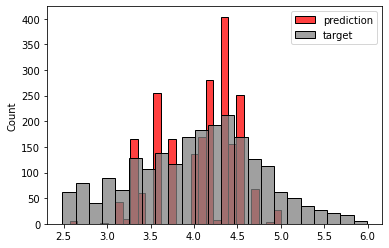

In [ ]:
sns.histplot(y_test_pred, label='prediction', color='red')
sns.histplot(y_test, label='target', color='gray')
plt.legend();

### 2.7 Tune the model ###
Find the best values for the following parameters:
* **Maximum depth of the tree**
* **Minimum number of samples required to be at a leaf node**

In [ ]:
for d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, None]:
    print('max_depth=%s' % d)
    print('*'*15)
    
    for s in [1, 5, 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500]:
        print('min_samples_leaf=%s' % s)
    
        dtr = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s)
        dtr.fit(X_train, y_train)   

        y_train_pred = dtr.predict(X_train)
        train_mse = mse(y_train, y_train_pred)
        train_rmse = np.sqrt(train_mse)
        print('train_rmse', '%.3f' % train_rmse)

        y_test_pred = dtr.predict(X_test)
        test_mse = mse(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        print('test_rmse', '%.3f' % test_rmse)

    print('-'*20)

max_depth=1
***************
min_samples_leaf=1
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=5
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=10
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=15
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=20
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=25
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=50
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=75
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=100
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=200
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=300
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=400
train_rmse 0.620
test_rmse 0.620
min_samples_leaf=500
train_rmse 0.620
test_rmse 0.620
--------------------
max_depth=2
***************
min_samples_leaf=1
train_rmse 0.599
test_rmse 0.602
min_samples_leaf=5
train_rmse 0.599
test_rmse 0.602
min_samples_leaf=10
train_rmse 0.599
test_rmse 0.602
min_samples_leaf=15
train_rmse 0.599
test_rmse 0.602
min_samples_leaf=20
t

### 2.8 Best parameters for the model ###

* **Maximum depth of the tree: 10**
* **Minimum number of samples required to be at a leaf node: 5**

In [ ]:
# Train the model
dtr = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)

In [ ]:
# Use the model
y_test_pred = dtr.predict(X_test)

In [ ]:
# Evaluate the model
test_mse = mse(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_rmse.round(3)

0.57

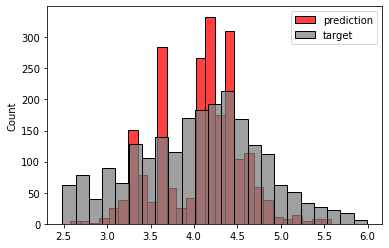

In [ ]:
sns.histplot(y_test_pred, label='prediction', color='red')
sns.histplot(y_test, label='target', color='gray')
plt.legend();